### 1. **Imports and Setup**
We start by importing the necessary libraries from `pgmpy` and setting up the GBN model structure.


In [2]:
import sys
sys.path.insert(0, 'C:/Users/MS/pgmpy')

from pgmpy.models import BayesianNetwork
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.utils import get_example_model

import networkx as nx
import matplotlib.pyplot as plt
# print("pgmpy import successful!")


c:\Users\MS\pgmpy\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. **Defining a Gaussian Bayesian Network Manually**

We will manually define a GBN by specifying both the structure and the parameters (Linear Gaussian CPDs) for the nodes.

#### Define the Network Structure
We will create a small GBN representing how `Pollution` and `Smoking` affect the probability of `Cancer`, and how `Cancer` affects `Xray` and `Dyspnoea`.


In [3]:
print(gaussian_model.nodes())
print(gaussian_model.edges())


NameError: name 'gaussian_model' is not defined

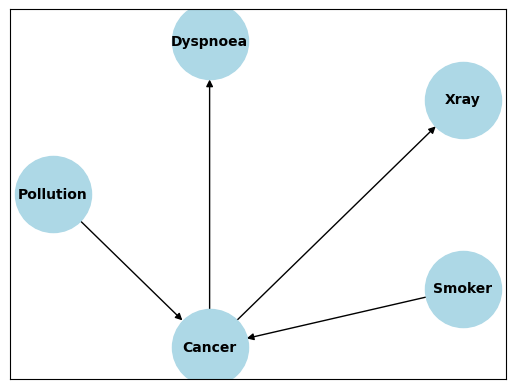

In [13]:
# Define the network structure
gaussian_model = BayesianNetwork([("Pollution", "Cancer"),
                                  ("Smoker", "Cancer"),
                                  ("Cancer", "Xray"),
                                  ("Cancer", "Dyspnoea")])

# Visualize the network
# pos = nx.spring_layout(gaussian_model)  # Position the nodes
# nx.draw(gaussian_model, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
pos = nx.shell_layout(gaussian_model)  # Try shell_layout instead of spring_layout
nx.draw_networkx(gaussian_model, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()



#### Define the CPDs
In GBNs, we use `LinearGaussianCPD` for continuous variables. Each node will have a Gaussian distribution with linear dependencies on its parent nodes.


In [16]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import TabularCPD

# Create a Bayesian model with CPDs (if not already done)
gaussian_model = BayesianNetwork([('Pollution', 'Cancer'), ('Smoker', 'Cancer'), ('Cancer', 'Xray'), ('Cancer', 'Dyspnoea')])

# Example CPDs (using TabularCPD for illustration, you can adapt these as needed)
cpd_pollution = TabularCPD(variable='Pollution', variable_card=2, values=[[0.9], [0.1]])
cpd_smoker = TabularCPD(variable='Smoker', variable_card=2, values=[[0.3], [0.7]])
cpd_cancer = TabularCPD(variable='Cancer', variable_card=2, 
                        values=[[0.03, 0.05, 0.001, 0.02], [0.97, 0.95, 0.999, 0.98]],
                        evidence=['Pollution', 'Smoker'], evidence_card=[2, 2])
cpd_xray = TabularCPD(variable='Xray', variable_card=2, 
                      values=[[0.9, 0.2], [0.1, 0.8]], 
                      evidence=['Cancer'], evidence_card=[2])
cpd_dysp = TabularCPD(variable='Dyspnoea', variable_card=2, 
                      values=[[0.65, 0.3], [0.35, 0.7]], 
                      evidence=['Cancer'], evidence_card=[2])

# Add CPDs to the model
gaussian_model.add_cpds(cpd_pollution, cpd_smoker, cpd_cancer, cpd_xray, cpd_dysp)

# Check if the model is valid
print(f"Is the model valid? {gaussian_model.check_model()}")

# Generate samples using BayesianModelSampling
sampler = BayesianModelSampling(gaussian_model)
samples = sampler.forward_sample(size=1000)  # Generate 1000 samples

# Display the first few samples
print(samples.head())


Is the model valid? True


Generating for node: Dyspnoea: 100%|██████████| 5/5 [00:00<00:00, 186.14it/s]

   Pollution  Cancer  Smoker  Xray  Dyspnoea
0          0       1       1     0         0
1          0       1       0     1         1
2          0       1       1     1         1
3          0       1       1     1         1
4          0       1       1     0         1


### 3. **Sampling from the Model**
Once the model is defined, we can generate samples from it using `BayesianModelSampling`. This is useful to understand how the model behaves and to generate data.


In [17]:
from pgmpy.sampling import BayesianModelSampling

# Initialize the sampling class
sampler = BayesianModelSampling(gaussian_model)

# Generate samples
samples = sampler.forward_sample(size=1000)
print(samples.head())

Generating for node: Dyspnoea: 100%|██████████| 5/5 [00:00<00:00, 315.96it/s]

   Pollution  Cancer  Smoker  Xray  Dyspnoea
0          0       1       1     1         1
1          0       1       0     1         1
2          0       1       1     0         0
3          0       1       0     1         1
4          0       1       0     0         0


### 4. **Inference in Gaussian Bayesian Networks**
Performing inference in a GBN allows us to compute conditional probabilities. For example, we might want to know the expected value of `Xray` given that a person has `Cancer`.

In [18]:
from pgmpy.inference import VariableElimination

# Initialize inference engine
inference = VariableElimination(gaussian_model)

# Perform inference
result = inference.query(variables=['Xray'], evidence={'Cancer': 1})
print(result)

+---------+-------------+
| Xray    |   phi(Xray) |
+=========+=============+
| Xray(0) |      0.2000 |
+---------+-------------+
| Xray(1) |      0.8000 |
+---------+-------------+


### 5. **Learning Parameters from Data**
If you have real-world continuous data, you can learn the parameters of a Gaussian Bayesian Network using Maximum Likelihood Estimation (MLE).

In [19]:
from pgmpy.estimators import MaximumLikelihoodEstimator
import pandas as pd

# Sample data
data = pd.DataFrame({
    'Pollution': [0.1, 0.2, 0.3, 0.4],
    'Smoker': [0.5, 0.6, 0.7, 0.8],
    'Cancer': [0.3, 0.5, 0.7, 0.9],
    'Xray': [0.4, 0.5, 0.6, 0.7],
    'Dyspnoea': [0.5, 0.6, 0.7, 0.8]
})

# Create a new model to learn
model_to_learn = BayesianNetwork([("Pollution", "Cancer"),
                                  ("Smoker", "Cancer"),
                                  ("Cancer", "Xray"),
                                  ("Cancer", "Dyspnoea")])

# Learn CPDs
model_to_learn.fit(data, estimator=MaximumLikelihoodEstimator)

# Display the learned CPDs
for cpd in model_to_learn.get_cpds():
    print(cpd)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Pollution': 'N', 'Smoker': 'N', 'Cancer': 'N', 'Xray': 'N', 'Dyspnoea': 'N'}


+----------------+------+
| Pollution(0.1) | 0.25 |
+----------------+------+
| Pollution(0.2) | 0.25 |
+----------------+------+
| Pollution(0.3) | 0.25 |
+----------------+------+
| Pollution(0.4) | 0.25 |
+----------------+------+
+-------------+----------------+-----+----------------+----------------+
| Pollution   | Pollution(0.1) | ... | Pollution(0.4) | Pollution(0.4) |
+-------------+----------------+-----+----------------+----------------+
| Smoker      | Smoker(0.5)    | ... | Smoker(0.7)    | Smoker(0.8)    |
+-------------+----------------+-----+----------------+----------------+
| Cancer(0.3) | 1.0            | ... | 0.25           | 0.0            |
+-------------+----------------+-----+----------------+----------------+
| Cancer(0.5) | 0.0            | ... | 0.25           | 0.0            |
+-------------+----------------+-----+----------------+----------------+
| Cancer(0.7) | 0.0            | ... | 0.25           | 0.0            |
+-------------+----------------+----

### 6. **Generating a Random Gaussian Bayesian Network**
Like with discrete networks, you can generate a random Gaussian Bayesian Network with `pgmpy`.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.continuous import LinearGaussianCPD
from pgmpy.utils import get_example_model

# Generate random GBN with 6 nodes and 10 edges
random_gaussian_model = BayesianNetwork.get_random(n_nodes=6, edge_prob=0.4, n_states=1, latents=False)

# Randomly generate CPDs for the network
random_gaussian_model.get_random_cpds(n_states=1, inplace=True)

# Get the network as a directed graph (DiGraph) in NetworkX
nx_graph = random_gaussian_model.to_networkx()

# Visualize the random model using networkx and matplotlib
pos = nx.spring_layout(nx_graph)  # Position the nodes
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
plt.title('Random Gaussian Bayesian Network')
plt.show()


ModuleNotFoundError: No module named 'pygraphviz'

In [1]:
# pip install pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\agraph.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\graphviz.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\scraper.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\testing.py -> build\lib.win-amd64-cpython-310\pygraphviz
      copying pygraphviz\__init__.py -> build\lib.win-amd64-cpython-310\pygraphviz
      creating build\lib.win-amd64-cpython-310\pygraphviz\tests
      copying pygraphviz\tests\test_attribute_defaults.py -> build\lib.win-amd64-cpython-310\pygraphviz\tests
      copying pygraphviz\tests\test_clear.py -> build\lib.win-amd64-cpython-310\pygraphviz\tests
      copying pygraphviz\test

### Conclusion
This tutorial demonstrates how to create, sample, and perform inference in Gaussian Bayesian Networks using `pgmpy`. You can define models manually, generate random networks, and even learn from data.